In [1]:
import pandas as pd
import numpy as np
import pickle
import random
from pathlib import Path

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC

from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import inspect

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from pathlib import Path


DATA_ROOT = Path('./data/')
MODELS_PATH = Path('./models/')

# input
DATASET_PATH = DATA_ROOT / 'train.csv'
TEST_PATH = DATA_ROOT / 'test.csv'
PREP_DATASET_PATH = DATA_ROOT / 'training_project_data_prep.csv'
TEST_DATASET_PATH = DATA_ROOT / 'final.csv'


# output
TRAIN_FULL_PATH = DATA_ROOT / 'training_project_train_full.csv'
TRAIN_PART_PATH = DATA_ROOT / 'training_project_train_part_b.csv'
TEST_PART_PATH = DATA_ROOT / 'training_project_test_part.csv'

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'

In [5]:
# функция отчетов
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [6]:
# функция предсказания
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [7]:
# функция балансировки классов
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [8]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [9]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [10]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [11]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

### Загрузка данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [12]:
df_basa = pd.read_csv(DATASET_PATH)
df_final = pd.read_csv(TEST_PATH)

**Выделение признакового описания и целевой переменной**

In [13]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
     'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score']

NUM_FEATURE_NAMES = ['Annual Income','Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership','Years in current job','Purpose', 'Term','Tax Liens','Bankruptcies','Number of Credit Problems']

### Заполнение пропусков/выбросов

In [14]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [15]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        self.annual_median =None
        self.years_in_mode =None
        self.credit_score_median =None
        self.bankruptcies_mode =None
        self.number_open_accounts_mode = None
        self.months_last_median = None
        self.current_loan_amount_median = None
        
    def fit(self, df):
        self.annual_median = df['Annual Income'].median()
        self.years_in_mode =df['Years in current job'].mode()[0]
        self.credit_score_median = df['Credit Score'].median()
        self.bankruptcies_mode =df['Bankruptcies'].mode()[0]
        self.current_loan_amount_median =df['Current Loan Amount'].median()
        self.number_open_accounts_mode =df['Number of Open Accounts'].mode()[0]
        self.maximum_open_credit_median=df['Maximum Open Credit'].median()
        self.months_last_median = df['Months since last delinquent'].median()
#         self.current_loan_amount_median = df['Current Loan Amount'].median()
       
        
        
    def transform(self, df):
        
        
        
        df['Purpose'] = df['Purpose'].map({'debt consolidation':'0', 'other':'1','home improvements':'2','business loan':'3',        
       'buy a car':'4', 'medical bills':'5', 'major purchase':'6','take a trip':'7','buy house':'8', 'small business':'9', 'wedding':'10',
                                           'moving':'11', 'educational expenses':'12', 'vacation':'13', 'renewable energy':'14'})
        df['Home Ownership'] = df['Home Ownership'].map({'Home Mortgage':'1', 'Rent':'2','Own Home':'3','Have Mortgage':'4'}) 
        
        df[['Purpose', 'Home Ownership']] = df[['Purpose', 'Home Ownership']].astype(int)
        
        
        # 1. Пропуски
        
        # Annual Income - годовой доход
        df['Annual Income'] = df['Annual Income'].fillna(self.annual_median)
        
        # Years in current job - количество лет на текущем месте работы
        df['Years in current job'] = df['Years in current job'].fillna(self.years_in_mode)
        
        # Bankruptcies - банкротства
        df['Bankruptcies'] = df['Bankruptcies'].fillna(self.bankruptcies_mode)
        
        # Credit Score - баллы кредитного рейтинга
        df['Credit Score'] = df['Credit Score'].fillna(self.credit_score_median)
        
#         df['Months since last delinquent'] = df['Months since last delinquent'].fillna(self.months_last_median)
#         df.loc[df['Months since last delinquent'] > 80, 'Months since last delinquent']= self.months_last_median
        
        # Выбросы
        
        # Credit Score - баллы кредитного рейтинга
        
#         #Current Loan Amount - текущая сумма кредита (37/38 - 61/62)
#         df.loc[df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = self.current_loan_amount_median
        
        # Выбросы
        
        # Annual Income - годовой доход
        
        df.loc[df['Maximum Open Credit'] > 10000000, 'Maximum Open Credit']= self.maximum_open_credit_median
        
        # Number of Open Accounts - количество открытых счетов
        df.loc[df['Number of Open Accounts'] > 35, 'Number of Open Accounts']= self.number_open_accounts_mode
        
        # Purpose
        df.loc[df['Purpose'] > 9, 'Purpose']= 9
        df.loc[df['Purpose'] == 1, 'Purpose']= 0
#         df.loc[df['Purpose'] ==  '11', 'Purpose']= '1'
#         df.loc[df['Purpose'] ==  '5', 'Purpose']= '1'
        df.loc[df['Home Ownership'] == 4, 'Home Ownership']= 1
    
        # Tax Liens
        df.loc[df['Tax Liens'] > 1, 'Tax Liens']= 1
        
        # Bankruptcies
        df.loc[df['Bankruptcies'] > 1, 'Bankruptcies']= 1
        
        # Bankruptcies
        df.loc[df['Number of Credit Problems'] > 3, 'Number of Credit Problems']= 3
        
        df[['Tax Liens', 'Bankruptcies','Number of Credit Problems']] = df[['Tax Liens', 'Bankruptcies','Number of Credit Problems']].astype(int)
        
        df['prog_current_loan_amount'] = 1
        df.loc[df['Current Loan Amount'] == 99999999, 'prog_current_loan_amount'] = 0
        df.loc[df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = self.current_loan_amount_median
        
        df['prog_credit_score'] = 0
        df.loc[df['Credit Score'] > 1000, 'prog_credit_score'] = 1
        df.loc[df['Credit Score'] > 1000, 'Credit Score'] = self.credit_score_median

        # Удаляем:
        
#         Months since last delinquent - количество месяцев с последней просрочки платежа
        if 'Months since last delinquent' in df.columns:
            df.drop('Months since last delinquent', axis=1, inplace=True)
         # Months since last delinquent - количество месяцев с последней просрочки платежа
        if 'Term' in df.columns:
            df.drop('Term', axis=1, inplace=True)    
            
            
            
        # Переводим в бин
        df['Years in current job'] = df['Years in current job'].map({'10+ years': '10', '1 year':'1', '2 years':'2', '3 years':'3','4 years':'4', '5 years':'5', '6 years':'6', '7 years':'7', '8 years':'8',
       '9 years':'9','< 1 year':'0'})   
        df['Years in current job'] = df['Years in current job'].astype(int)
       
#         df['Term'] = df['Term'].map({'Long Term':'1', 'Short Term':'2'})
        
       # Построение новых признаков
#         df['prog_credit_score'] = 0
#         df.loc[df['Credit Score'] > 1000, 'prog_credit_score'] = 1
        
        
        # Dummies
#         for cat_colname in df.select_dtypes(include='object').columns[1:]:
#             df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
    
        return df

In [16]:
imputer = FeatureImputer()

imputer.fit(df_basa) # расчет медиан

df_basa = imputer.transform(df_basa)
df_final = imputer.transform(df_final)

In [17]:
# графики выбросов
# df_basa[NUM_FEATURE_NAMES].hist(figsize=(16, 16), bins=20, grid=False);

### Сохранение обучающего датасета

In [18]:
df_basa.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

In [19]:
df = pd.read_csv(PREP_DATASET_PATH)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Home Ownership             7500 non-null   int64  
 1   Annual Income              7500 non-null   float64
 2   Years in current job       7500 non-null   int64  
 3   Tax Liens                  7500 non-null   int64  
 4   Number of Open Accounts    7500 non-null   float64
 5   Years of Credit History    7500 non-null   float64
 6   Maximum Open Credit        7500 non-null   float64
 7   Number of Credit Problems  7500 non-null   int64  
 8   Bankruptcies               7500 non-null   int64  
 9   Purpose                    7500 non-null   int64  
 10  Current Loan Amount        7500 non-null   float64
 11  Current Credit Balance     7500 non-null   float64
 12  Monthly Debt               7500 non-null   float64
 13  Credit Score               7500 non-null   float

In [21]:
df.head(10)

Home Ownership  Annual Income  Years in current job  Tax Liens  \
0               3       482087.0                    10          0   
1               3      1025487.0                    10          0   
2               1       751412.0                     8          0   
3               3       805068.0                     6          0   
4               2       776264.0                     8          0   
5               2      1168386.0                     7          0   
6               1      1511108.0                    10          0   
7               2      1040060.0                    10          0   
8               1      1168386.0                     5          0   
9               1      1168386.0                     1          0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   
5                     12.0                     14.6             366784.0   
6                      9.0                     20.3             388124.0   
7                     13.0                     12.0             330374.0   
8                     17.0                     15.7                  0.0   
9                     10.0                     24.6             511302.0   

   Number of Credit Problems  Bankruptcies  Purpose  Current Loan Amount  \
0                          1             1        0             309573.0   
1                          0             0        0             264968.0   
2                          0             0        0             309573.0   
3                          1             1        0             121396.0   
4                          1             0        0             125840.0   
5                          0             0        0             337304.0   
6                          0             0        2             309573.0   
7                          0             0        0             250888.0   
8                          1             1        2             129734.0   
9                          0             0        0             572880.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  \
0                 47386.0        7914.0         749.0               0   
1                394972.0       18373.0         737.0               1   
2                308389.0       13651.0         742.0               0   
3                 95855.0       11338.0         694.0               0   
4                 93309.0        7180.0         719.0               0   
5                165680.0       18692.0         731.0               1   
6                 51623.0        2317.0         745.0               0   
7                 89015.0       19761.0         705.0               1   
8                    19.0          17.0         731.0               0   
9                205333.0       17613.0         731.0               1   

   prog_current_loan_amount  prog_credit_score  
0                         0                  0  
1                         1                  0  
2                         0                  0  
3                         1                  0  
4                         1                  0  
5                         1                  0  
6                         0                  0  
7                         1                  0  
8                         1                  0  
9                         1                  0

**Выделение целевой переменной и групп признаков**

In [22]:
TARGET_NAME = 'Credit Default'
DELETE = 'Months since last delinquent'
BASE_FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Purpose',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score','prog_current_loan_amount','prog_credit_score']

# NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

NUM_FEATURE_NAMES = ['Annual Income','Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit','Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score','prog_current_loan_amount','prog_credit_score']
CAT_FEATURE_NAMES = ['Home Ownership','Years in current job','Purpose','Tax Liens','Bankruptcies','Number of Credit Problems']

## **Корреляция с базовыми признаками**

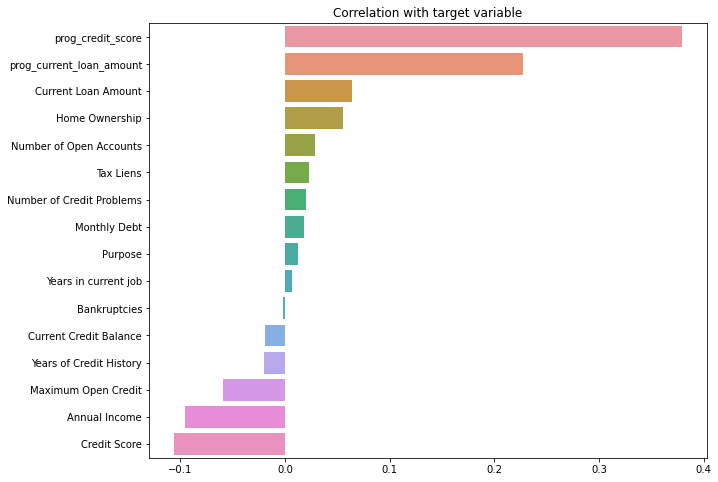

In [23]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Анализ категориальных признаков

**Оценка признака 'Years in current job' в разрезе целевой переменной**

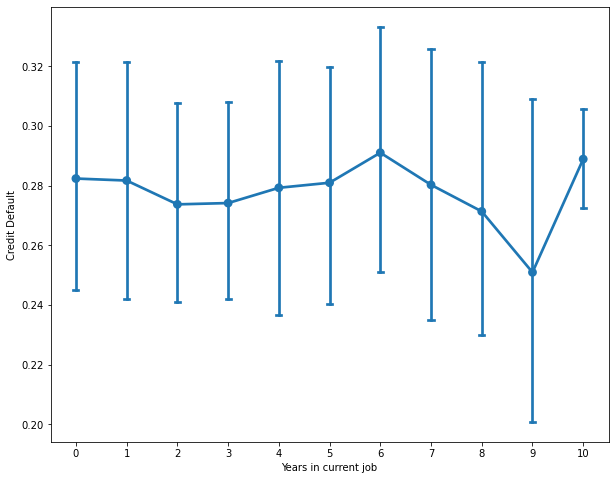

In [24]:
plt.figure(figsize=(10, 8))

sns.pointplot(x='Years in current job', y=TARGET_NAME, data=df, capsize=.1,);

*Проверим нашу гипотезу, используя критерий Хи-квадрат Пирсона*

In [25]:
# df['Id'] = df.index
# years_current_job_and_target_s = df.loc[df['Years in current job'].isin([1, 4]), ['Id', 'Years in current job', TARGET_NAME]]

# table = years_current_job_and_target_s.pivot_table(values='Id', index='Years in current job', columns=TARGET_NAME, aggfunc='count')
# table

# chi2, p, _, _ = chi2_contingency(table)
# p

In [26]:
# Обьединяем 0 и 1
def change_years_current_job(df):
    df.loc[df['Years in current job'].isin([0, 1]),'Years in current job'] = 0
    df.loc[df['Years in current job'].isin([2, 3]),'Years in current job'] = 2
    df.loc[df['Years in current job'].isin([4, 5]),'Years in current job'] = 4
    df.loc[df['Years in current job'].isin([7, 8]),'Years in current job'] = 7
    df.loc[df['Years in current job'].isin([6, 10]),'Years in current job'] = 6
    return df


df_final = change_years_current_job(df_final)
df = change_years_current_job(df)

In [27]:
df['Years in current job'].value_counts()

6    3129
2    1325
0    1067
4     985
7     735
9     259
Name: Years in current job, dtype: int64

In [28]:
df_final['Years in current job'].value_counts()

6    1033
2     440
0     360
4     321
7     247
9      99
Name: Years in current job, dtype: int64

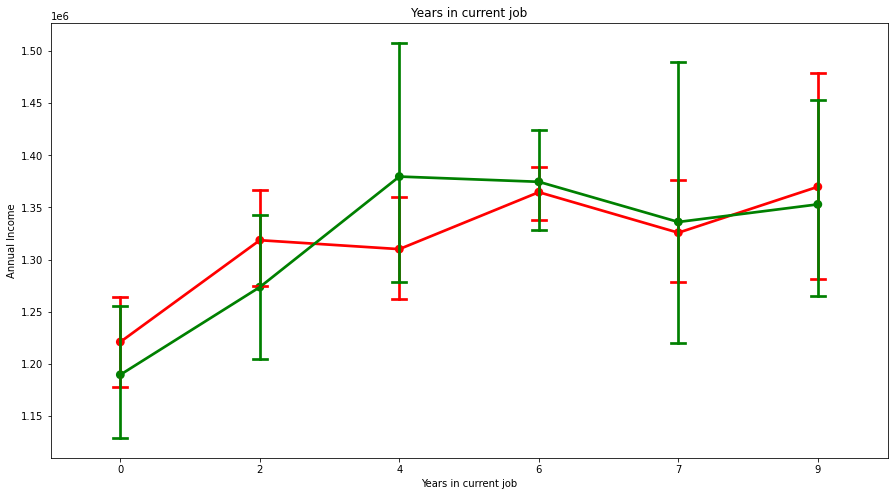

In [29]:
num_feature = 'Annual Income'
col = 'Years in current job'
plt.figure(figsize=(15,8))
sns.pointplot(x=col, y=num_feature, data=df, capsize=.1, label='train', color='r')
sns.pointplot(x=col, y=num_feature, data=df_final, capsize=.1, label='test', color='g')
plt.title(col)
plt.show()

**Оценка признака'Home Ownership'  в разрезе целевой переменной**

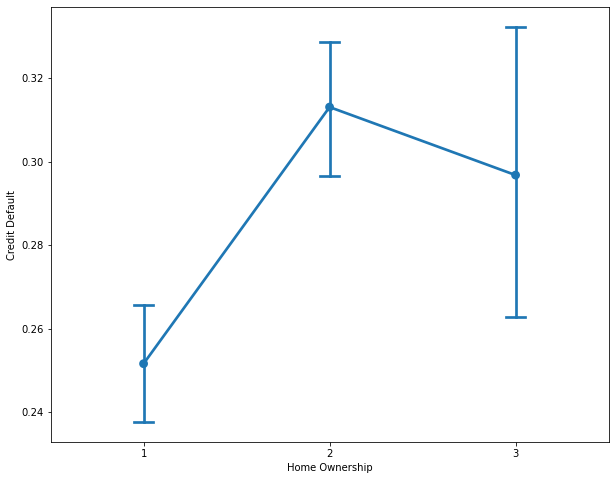

In [30]:
plt.figure(figsize=(10, 8))

sns.pointplot(x='Home Ownership', y=TARGET_NAME, data=df, capsize=.1,);

In [31]:
# df['Id'] = df.index
# home_ownership_and_target_s = df.loc[df[ 'Home Ownership' ].isin([2, 3]), ['Id',  'Home Ownership' , 'Credit Default']]

# table = home_ownership_and_target_s.pivot_table(values='Id', index='Home Ownership', columns='Credit Default', aggfunc='count')

# chi2, p, _, _ = chi2_contingency(table)
# p

In [32]:
# # Обьединяем 
# def change_home_ownership(df):
#     df.loc[df['Home Ownership'].isin(['2', '3']),'Home Ownership'] = 0
    
#     return df


# df_final = change_home_ownership(df_final)
# df = change_home_ownership(df)

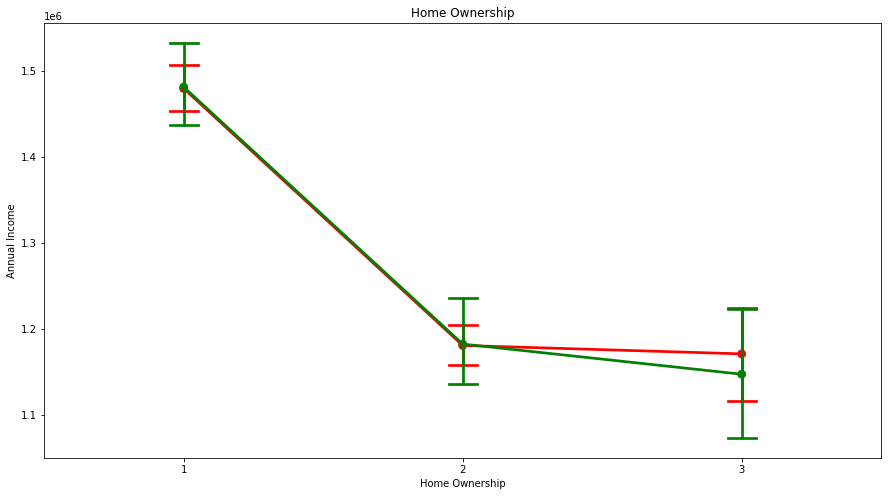

In [33]:
num_feature = 'Annual Income'
col = 'Home Ownership'
plt.figure(figsize=(15,8))
sns.pointplot(x=col, y=num_feature, data=df, capsize=.1, label='train', color='r')
sns.pointplot(x=col, y=num_feature, data=df_final, capsize=.1, label='test', color='g')
plt.title(col)
plt.show()

**Оценка признака 'Purpose' в разрезе целевой переменной**

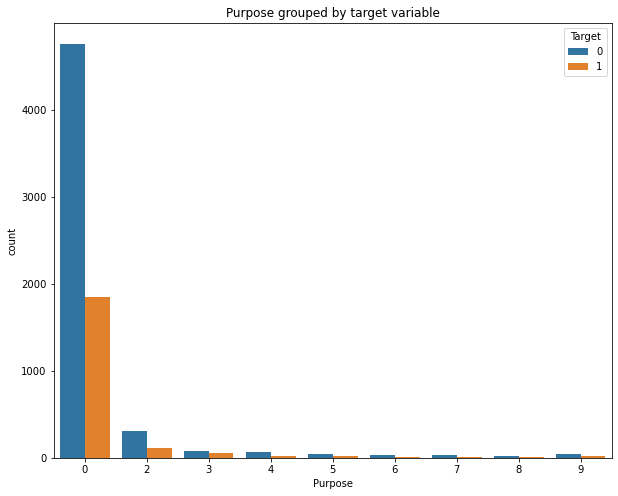

In [34]:
plt.figure(figsize=(10, 8))

sns.countplot(x= 'Purpose', hue=TARGET_NAME, data=df)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

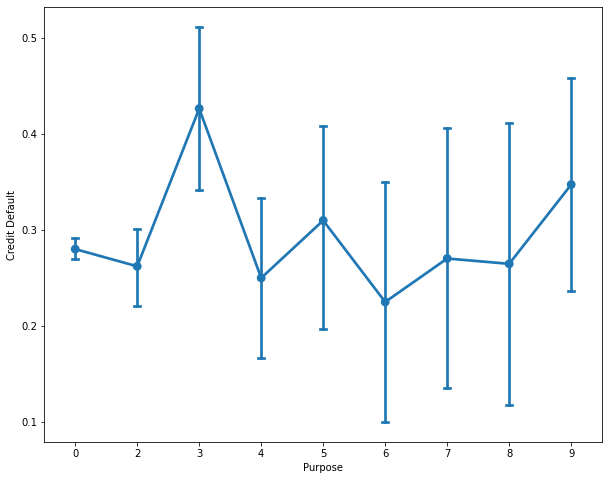

In [35]:
plt.figure(figsize=(10, 8))

sns.pointplot(x='Purpose', y=TARGET_NAME, data=df, capsize=.1,);

In [36]:
# df['Id'] = df.index
# home_ownership_and_target_s = df.loc[df[ 'Purpose' ].isin([11, 13]), ['Id',  'Purpose' , 'Credit Default']]

# table = home_ownership_and_target_s.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')

# chi2, p, _, _ = chi2_contingency(table)
# p

In [37]:
# Обьединяем 
def change_purpose(df):
    df.loc[df['Purpose'].isin(['6', '8']),'Purpose'] = 6
    df.loc[df['Purpose'].isin(['7', '5']),'Purpose'] = 5
    df.loc[df['Purpose'].isin(['2', '4']),'Purpose'] = 2
    return df


df_final = change_purpose(df_final)
df = change_purpose(df)

In [38]:
df_final['Purpose'].value_counts()

0    2213
2     174
5      41
3      30
6      28
9      14
Name: Purpose, dtype: int64

In [39]:
df['Purpose'].value_counts()

0    6609
2     508
3     129
5     108
6      74
9      72
Name: Purpose, dtype: int64

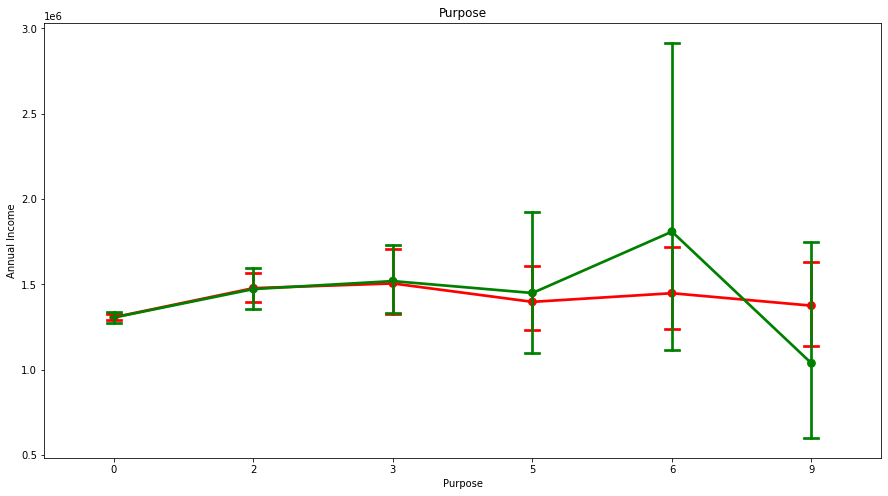

In [40]:
num_feature = 'Annual Income'
col = 'Purpose'
plt.figure(figsize=(15,8))
sns.pointplot(x=col, y=num_feature, data=df, capsize=.1, label='train', color='r')
sns.pointplot(x=col, y=num_feature, data=df_final, capsize=.1, label='test', color='g')
plt.title(col)
plt.show()

### Оценка признака 'Tax Liens' в разрезе целевой переменной

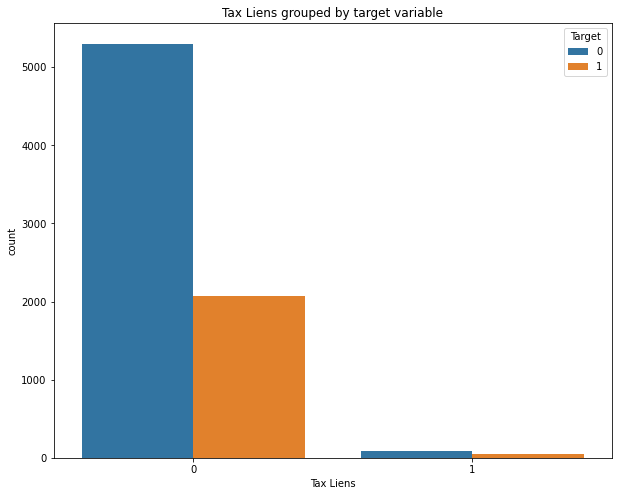

In [41]:
plt.figure(figsize=(10, 8))

sns.countplot(x= 'Tax Liens', hue=TARGET_NAME, data=df)
plt.title('Tax Liens grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

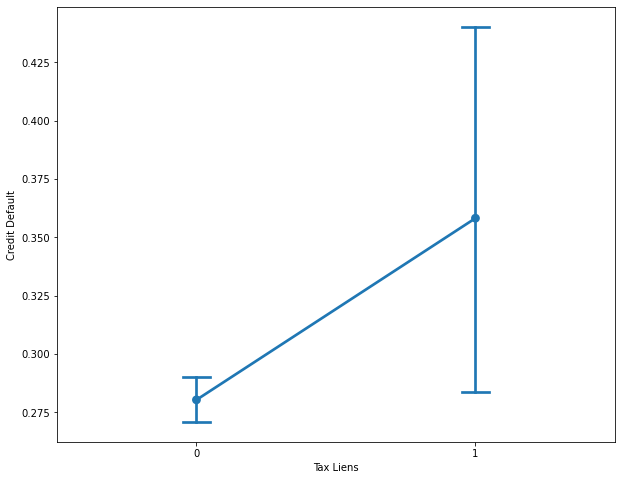

In [42]:
plt.figure(figsize=(10, 8))

sns.pointplot(x='Tax Liens', y=TARGET_NAME, data=df, capsize=.1,);

In [43]:
# df['Id'] = df.index
# home_ownership_and_target_s = df.loc[df[ 'Tax Liens' ].isin([2, 3]), ['Id',  'Tax Liens' , 'Credit Default']]

# table = home_ownership_and_target_s.pivot_table(values='Id', index='Tax Liens', columns='Credit Default', aggfunc='count')

# chi2, p, _, _ = chi2_contingency(table)
# p

In [44]:
# # Обьединяем 
# def change_purpose(df):
#     df.loc[df['Purpose'].isin(['6', '8']),'Purpose'] = 6
#     df.loc[df['Purpose'].isin(['7', '5']),'Purpose'] = 5
#     df.loc[df['Purpose'].isin(['2', '4']),'Purpose'] = 2
#     return df


# df_final = change_purpose(df_final)
# df = change_purpose(df)

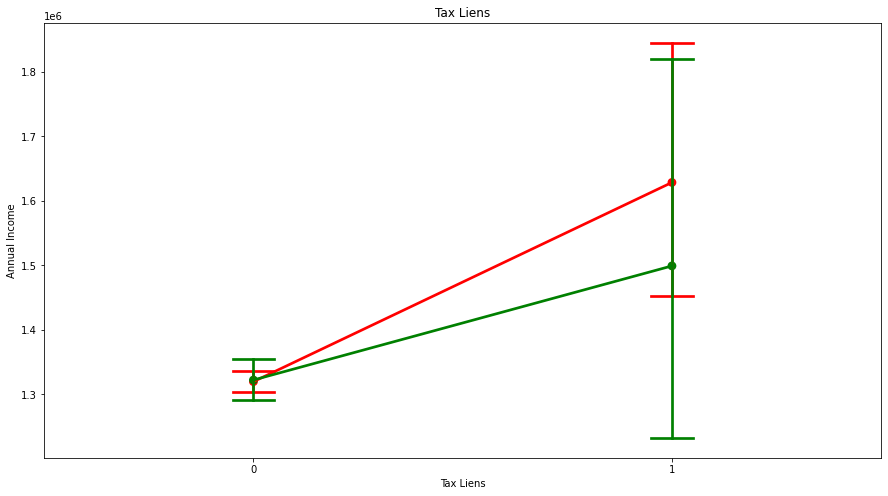

In [45]:
num_feature = 'Annual Income'
col = 'Tax Liens'
plt.figure(figsize=(15,8))
sns.pointplot(x=col, y=num_feature, data=df, capsize=.1, label='train', color='r')
sns.pointplot(x=col, y=num_feature, data=df_final, capsize=.1, label='test', color='g')
plt.title(col)
plt.show()

### Оценка признака 'Bankruptcies' в разрезе целевой переменной

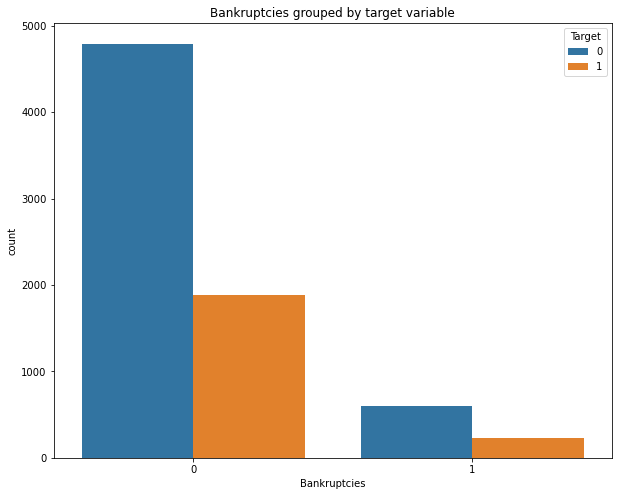

In [46]:
plt.figure(figsize=(10, 8))

sns.countplot(x= 'Bankruptcies', hue=TARGET_NAME, data=df)
plt.title('Bankruptcies grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

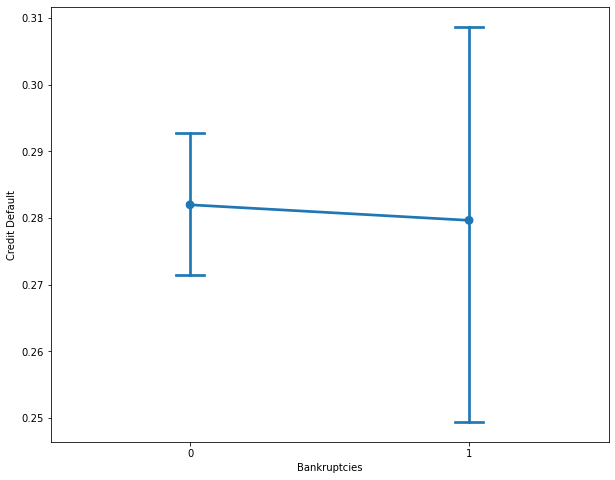

In [47]:
plt.figure(figsize=(10, 8))

sns.pointplot(x='Bankruptcies', y=TARGET_NAME, data=df, capsize=.1,);

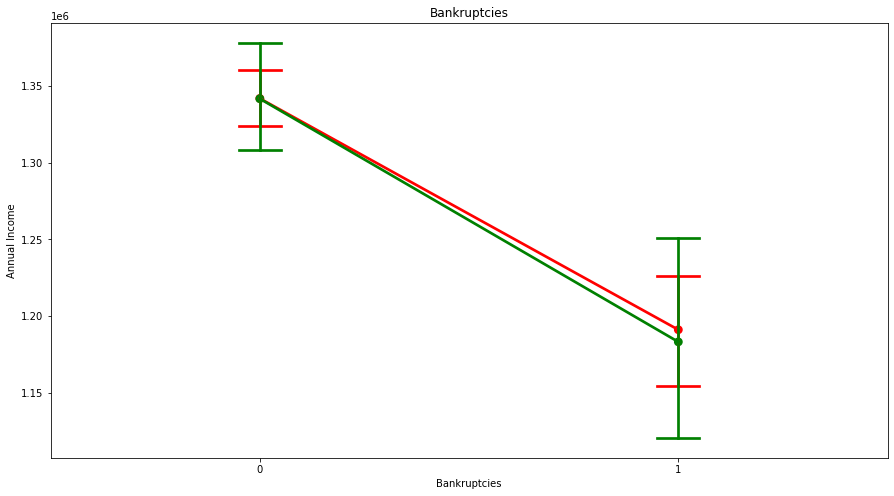

In [48]:
num_feature = 'Annual Income'
col = 'Bankruptcies'
plt.figure(figsize=(15,8))
sns.pointplot(x=col, y=num_feature, data=df, capsize=.1, label='train', color='r')
sns.pointplot(x=col, y=num_feature, data=df_final, capsize=.1, label='test', color='g')
plt.title(col)
plt.show()

### Оценка признака 'Number of Credit Problems' в разрезе целевой переменной

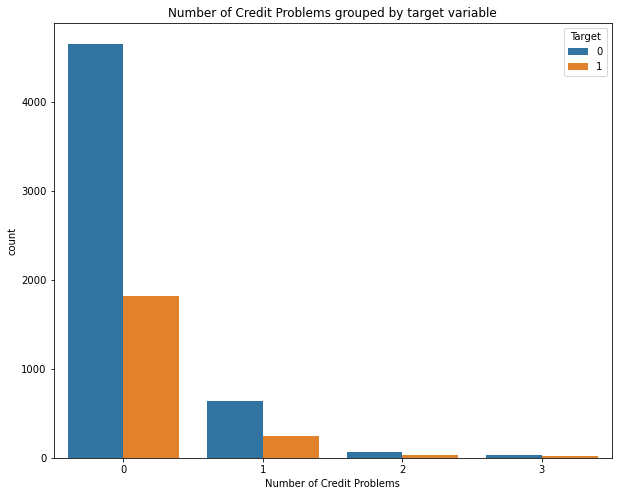

In [49]:
plt.figure(figsize=(10, 8))

sns.countplot(x= 'Number of Credit Problems', hue=TARGET_NAME, data=df)
plt.title('Number of Credit Problems grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

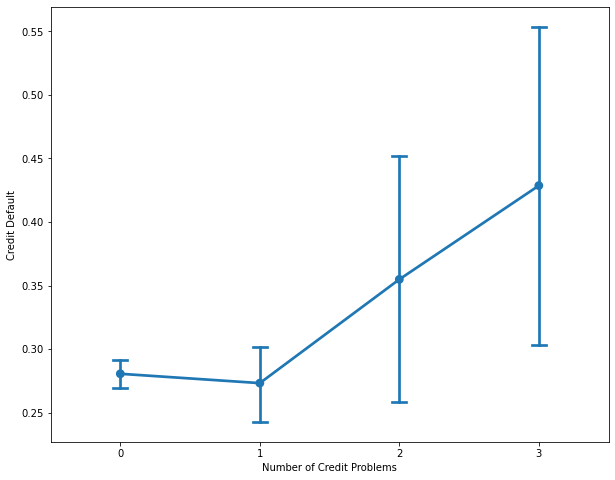

In [50]:
plt.figure(figsize=(10, 8))

sns.pointplot(x='Number of Credit Problems', y=TARGET_NAME, data=df, capsize=.1,);

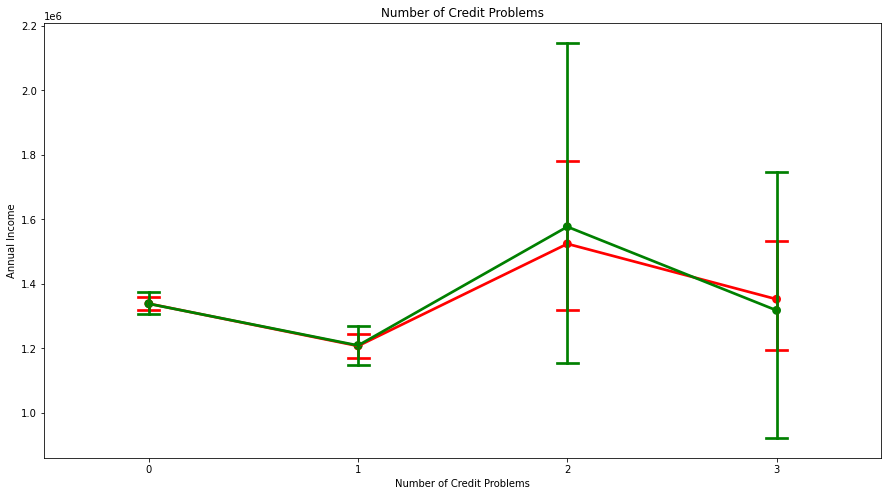

In [51]:
num_feature = 'Annual Income'
col = 'Number of Credit Problems'
plt.figure(figsize=(15,8))
sns.pointplot(x=col, y=num_feature, data=df, capsize=.1, label='train', color='r')
sns.pointplot(x=col, y=num_feature, data=df_final, capsize=.1, label='test', color='g')
plt.title(col)
plt.show()

### Анализ вещественных признаков

**Оценка признака 'Credit Score' в разрезе целевой переменной**

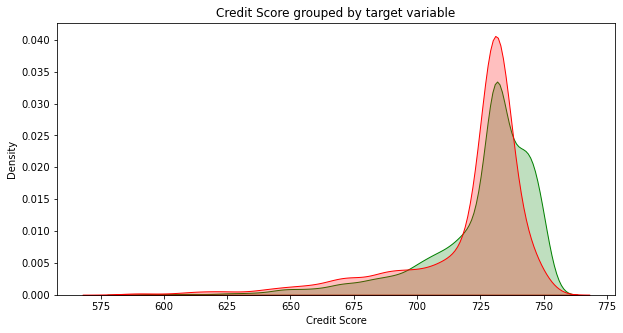

In [52]:
credit_score_with_target = df[['Credit Score', TARGET_NAME]]
credit_score = credit_score_with_target['Credit Score']
credit_score_target_0 = credit_score[credit_score_with_target[TARGET_NAME] == 0]
credit_score_target_1 = credit_score[credit_score_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(credit_score_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

In [53]:
shapiro(df['Credit Score'])

ShapiroResult(statistic=0.7849956750869751, pvalue=0.0)

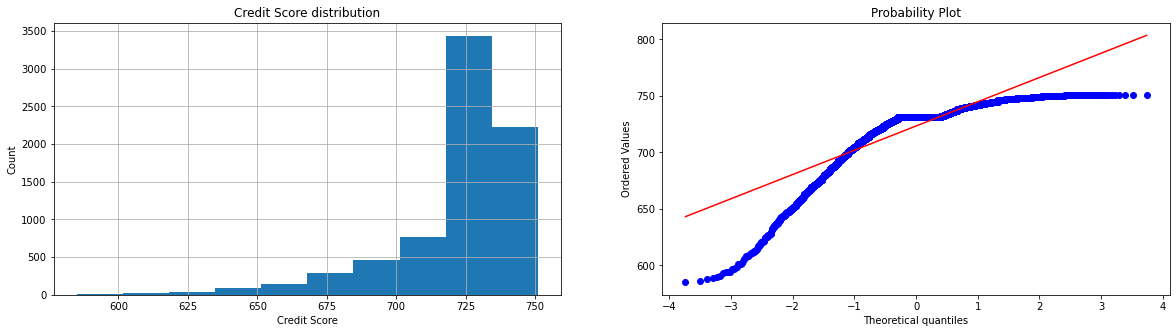

In [54]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
credit_score.hist()

plt.subplot(122)
probplot(credit_score, dist='norm', plot=plt)

plt.show()

In [55]:
mannwhitneyu(credit_score_target_0, credit_score_target_1)

MannwhitneyuResult(statistic=4724307.5, pvalue=2.4689678041362667e-31)

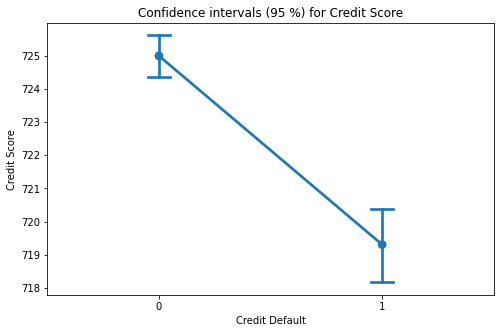

In [56]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=credit_score_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

**Оценка признака 'Current Loan Amount' в разрезе целевой переменной**

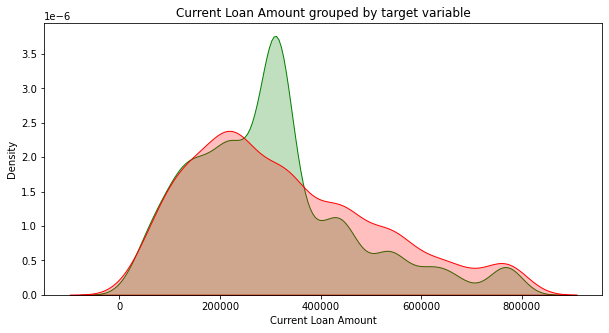

In [57]:
current_loan_amount_with_target = df[['Current Loan Amount', TARGET_NAME]]
current_loan_amount = current_loan_amount_with_target['Current Loan Amount']
current_loan_amount_target_0 = current_loan_amount[current_loan_amount_with_target[TARGET_NAME] == 0]
current_loan_amount_target_1 = current_loan_amount[current_loan_amount_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(current_loan_amount_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(current_loan_amount_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.show()

In [58]:
shapiro(current_loan_amount)

ShapiroResult(statistic=0.9422052502632141, pvalue=0.0)

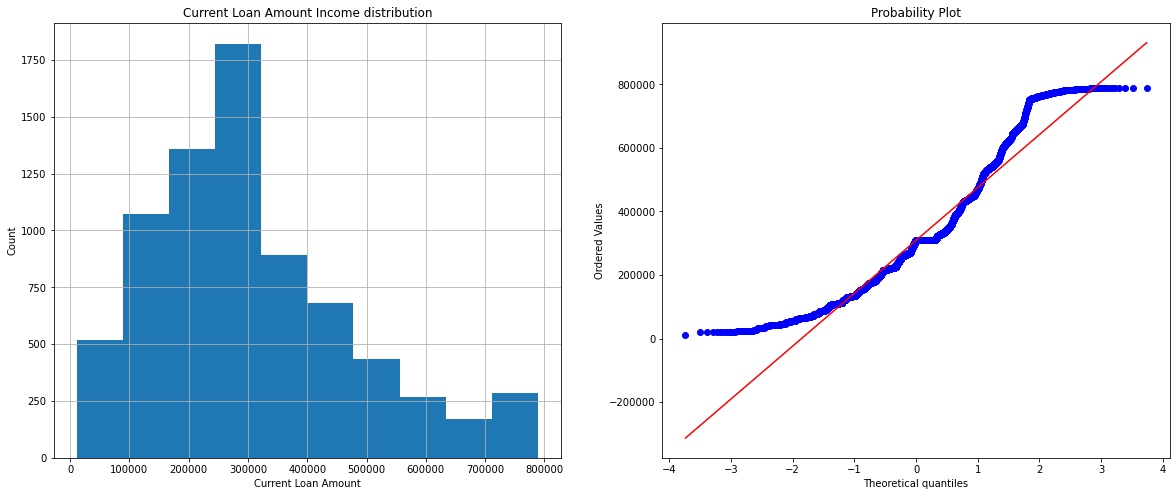

In [59]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Loan Amount')
ax1.set_ylabel('Count')
ax1.set_title('Current Loan Amount Income distribution')
current_loan_amount.hist()

plt.subplot(122)
probplot(current_loan_amount, dist='norm', plot=plt)

plt.show()

### Анализ признакового пространства

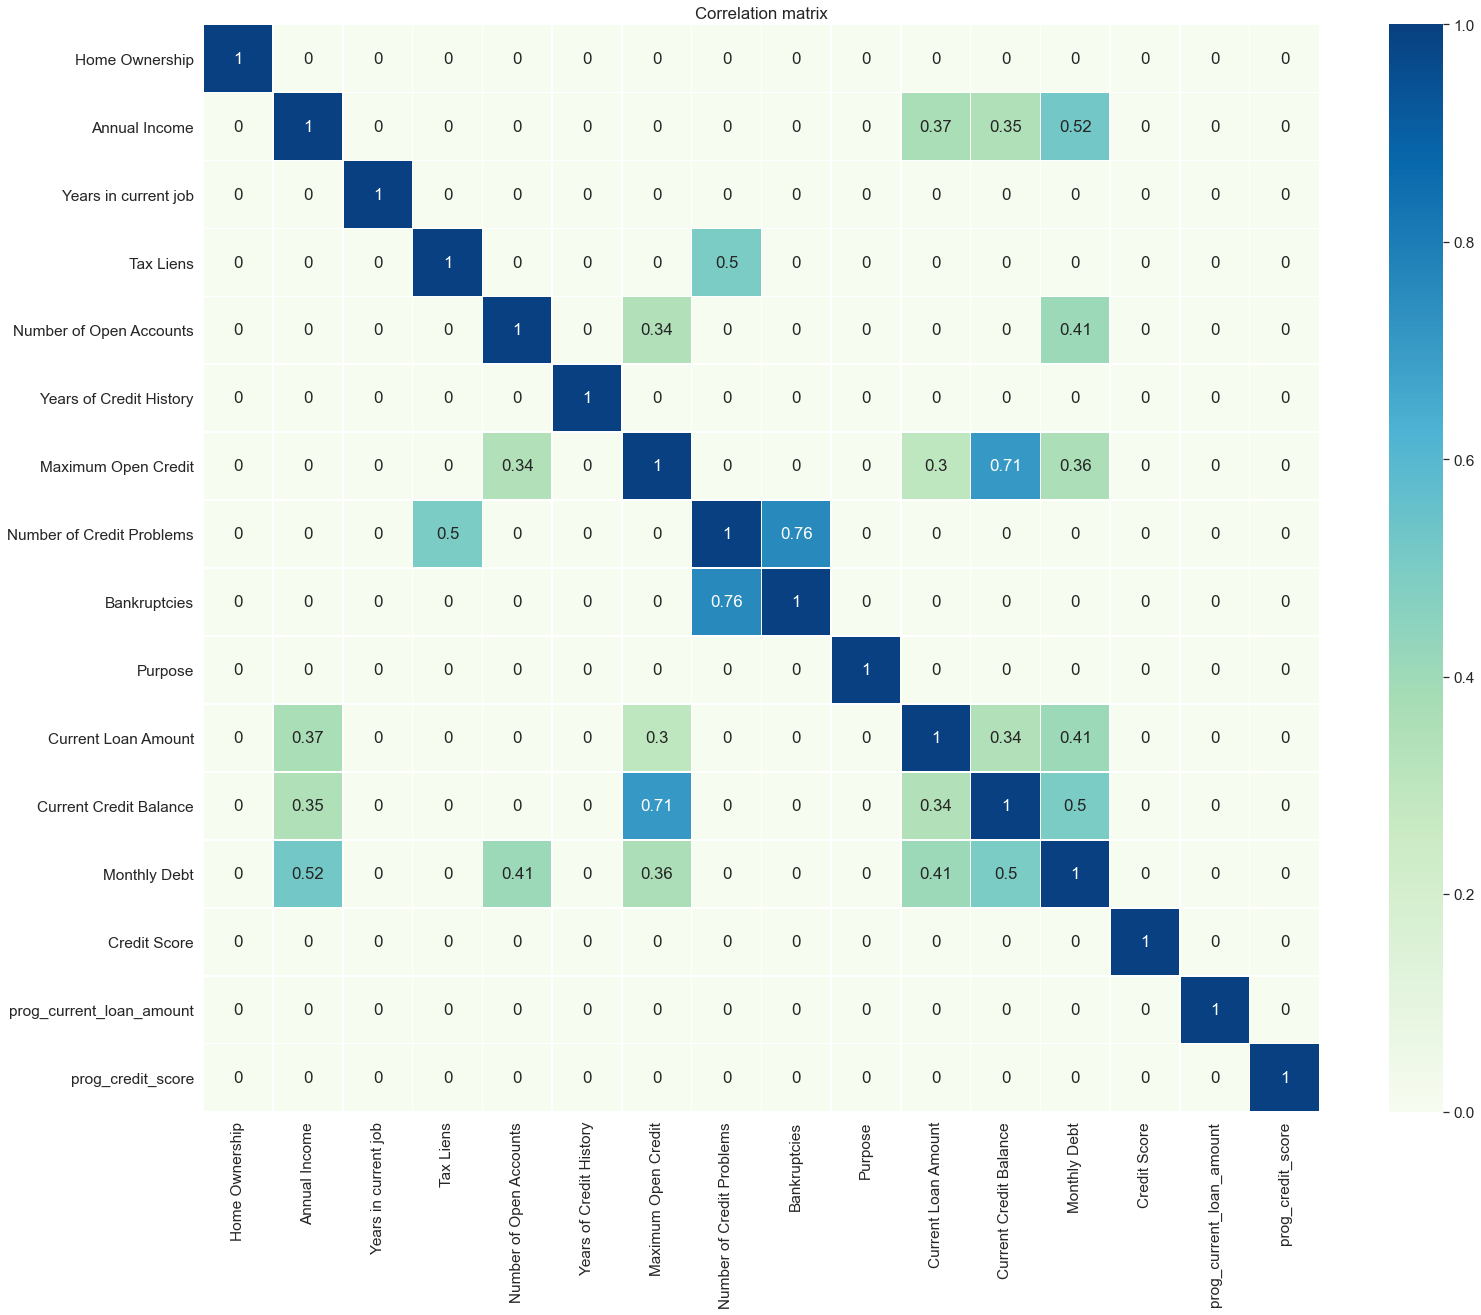

In [60]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = df[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Проверим распределения вещественных признаков на трейне и тесте**

Annual Income
MannwhitneyuResult(statistic=9361624.5, pvalue=0.45720685796373933)


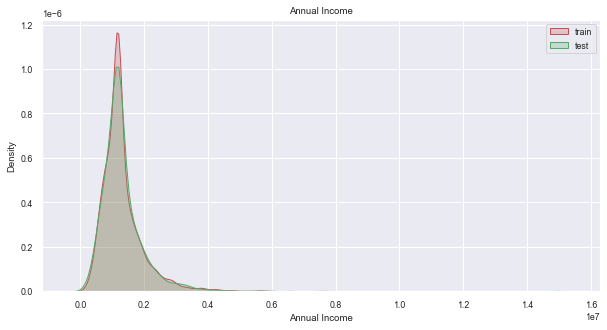

Number of Open Accounts
MannwhitneyuResult(statistic=9279216.5, pvalue=0.22119739091419988)


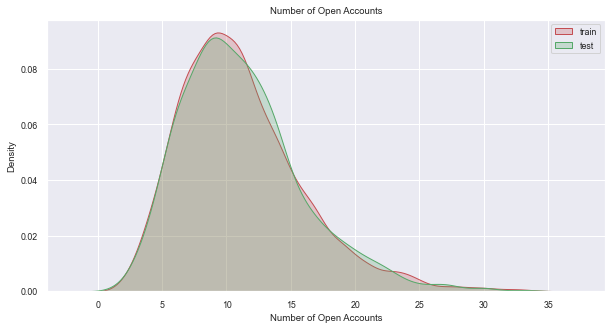

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


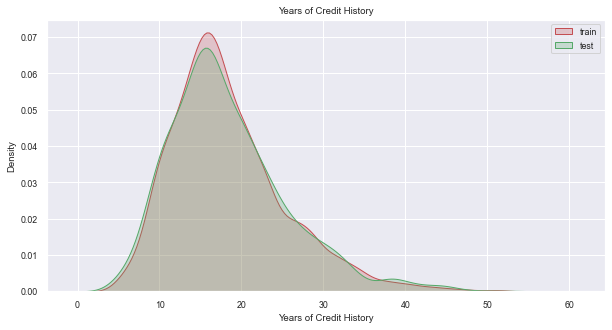

Maximum Open Credit
MannwhitneyuResult(statistic=9332858.5, pvalue=0.3680165255827398)


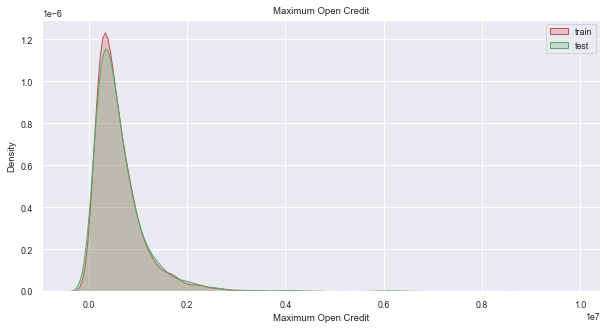

Current Loan Amount
MannwhitneyuResult(statistic=9221649.5, pvalue=0.10977704624662077)


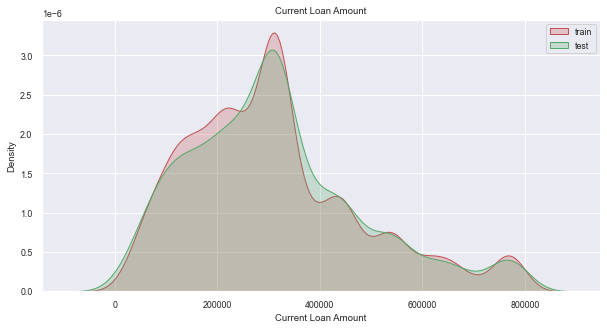

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


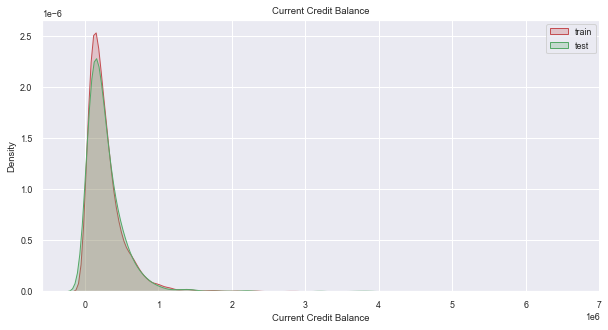

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


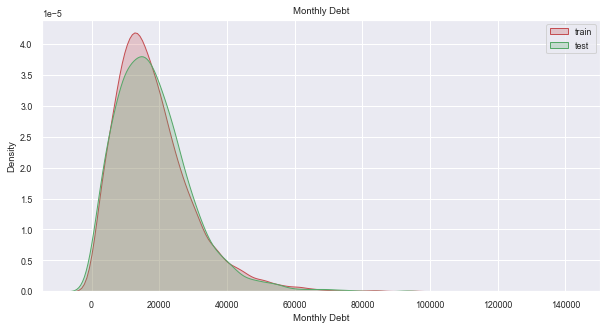

Credit Score
MannwhitneyuResult(statistic=9247418.5, pvalue=0.15114281548880665)


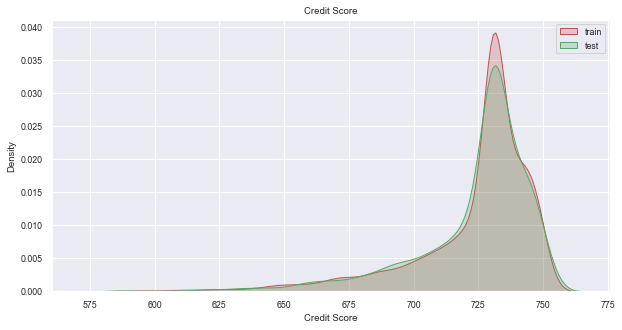

prog_current_loan_amount
MannwhitneyuResult(statistic=9348750.0, pvalue=0.35286157280000413)


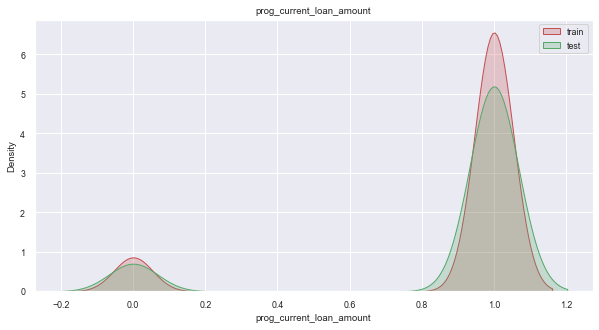

prog_credit_score
MannwhitneyuResult(statistic=9275000.0, pvalue=0.022281931660039042)


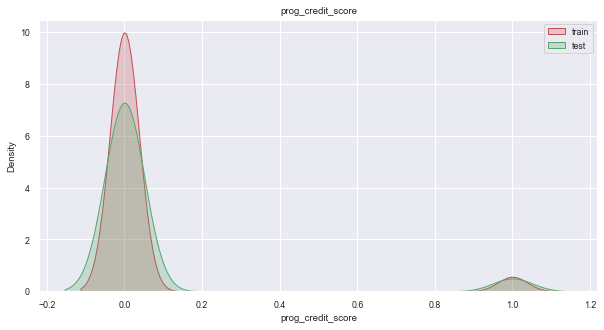

In [61]:
figsize = (10, 5)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df[col], shade=True, label='train', color='r')
    sns.kdeplot(df_final[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df[col], df_final[col]))
    plt.legend()
    plt.title(col)
    plt.show()

**Проверим распределения категориальных признаков на трейне и тесте**

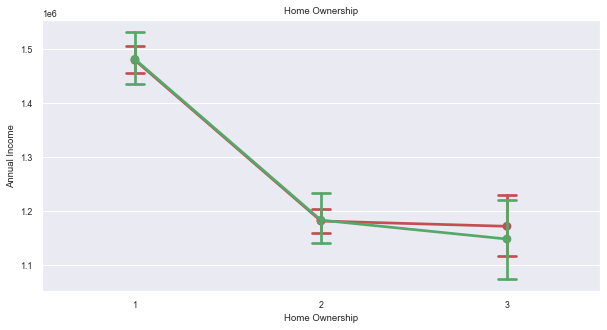

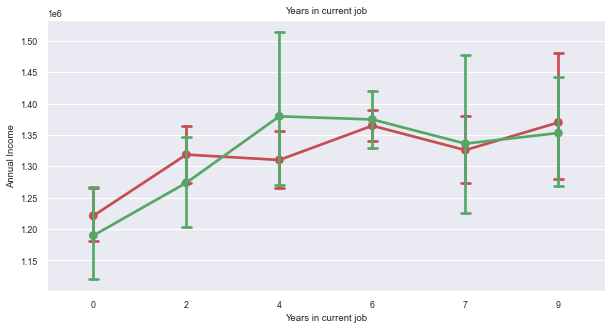

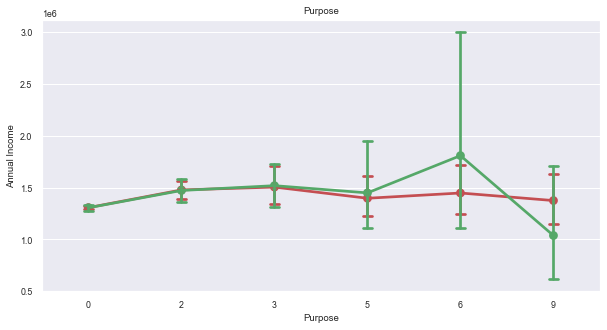

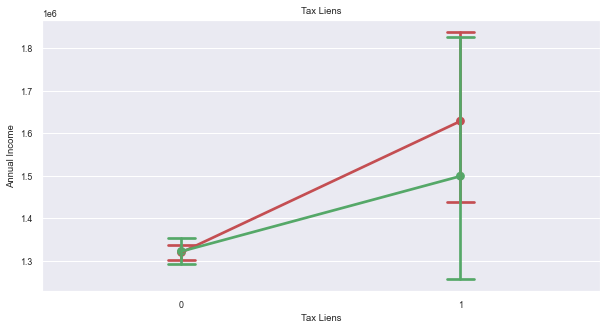

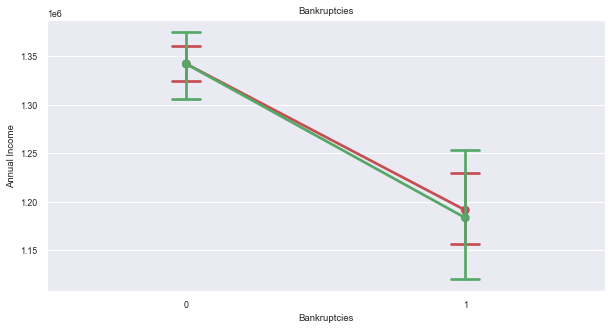

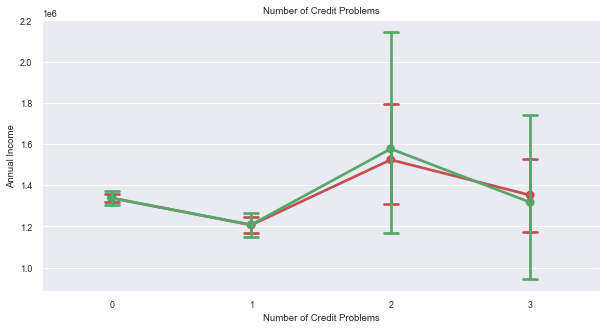

In [62]:
num_feature = 'Annual Income'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_final, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

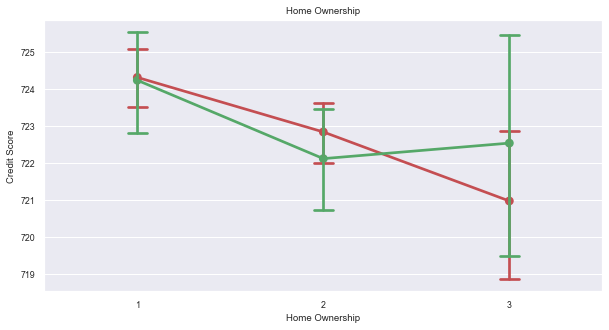

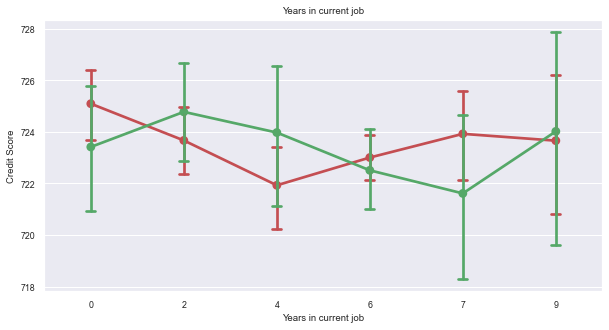

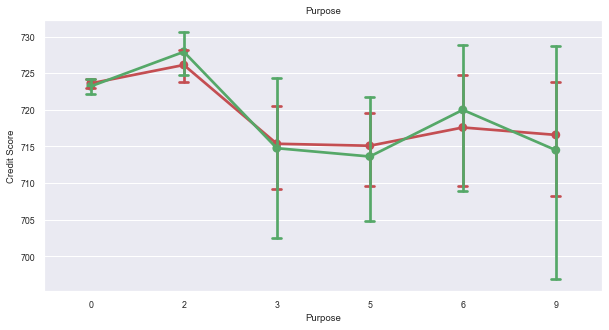

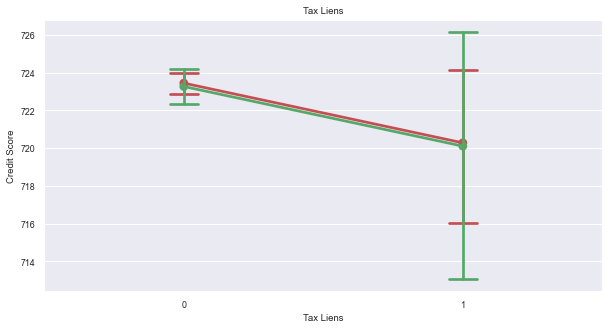

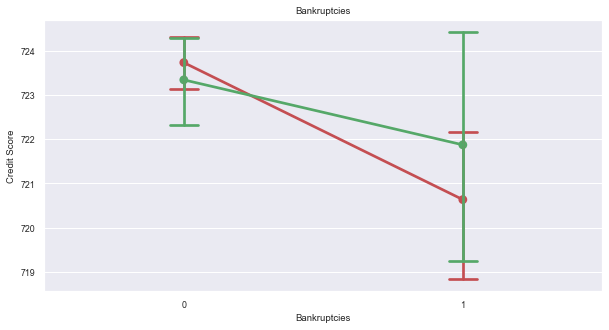

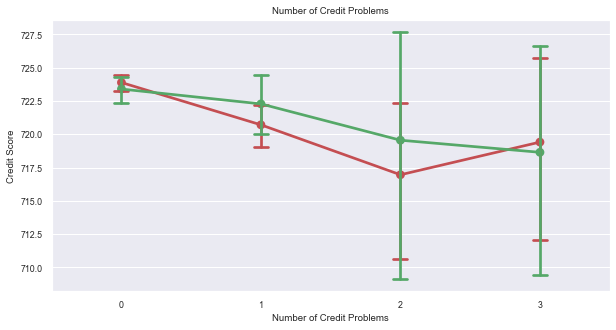

In [63]:
num_feature = 'Credit Score'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_final, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

In [64]:
df.head(10)

Home Ownership  Annual Income  Years in current job  Tax Liens  \
0               3       482087.0                     6          0   
1               3      1025487.0                     6          0   
2               1       751412.0                     7          0   
3               3       805068.0                     6          0   
4               2       776264.0                     7          0   
5               2      1168386.0                     7          0   
6               1      1511108.0                     6          0   
7               2      1040060.0                     6          0   
8               1      1168386.0                     4          0   
9               1      1168386.0                     0          0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   
5                     12.0                     14.6             366784.0   
6                      9.0                     20.3             388124.0   
7                     13.0                     12.0             330374.0   
8                     17.0                     15.7                  0.0   
9                     10.0                     24.6             511302.0   

   Number of Credit Problems  Bankruptcies  Purpose  Current Loan Amount  \
0                          1             1        0             309573.0   
1                          0             0        0             264968.0   
2                          0             0        0             309573.0   
3                          1             1        0             121396.0   
4                          1             0        0             125840.0   
5                          0             0        0             337304.0   
6                          0             0        2             309573.0   
7                          0             0        0             250888.0   
8                          1             1        2             129734.0   
9                          0             0        0             572880.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  \
0                 47386.0        7914.0         749.0               0   
1                394972.0       18373.0         737.0               1   
2                308389.0       13651.0         742.0               0   
3                 95855.0       11338.0         694.0               0   
4                 93309.0        7180.0         719.0               0   
5                165680.0       18692.0         731.0               1   
6                 51623.0        2317.0         745.0               0   
7                 89015.0       19761.0         705.0               1   
8                    19.0          17.0         731.0               0   
9                205333.0       17613.0         731.0               1   

   prog_current_loan_amount  prog_credit_score  
0                         0                  0  
1                         1                  0  
2                         0                  0  
3                         1                  0  
4                         1                  0  
5                         1                  0  
6                         0                  0  
7                         1                  0  
8                         1                  0  
9                         1                  0

### Сохранение

In [65]:
df.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

In [66]:
df_final.to_csv(TEST_DATASET_PATH, index=False, encoding='utf-8')

In [67]:
df = pd.read_csv(PREP_DATASET_PATH)


In [68]:
df_test_pred = pd.read_csv(TEST_DATASET_PATH)

### Отбор признаков

In [69]:

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

### Разбиение на train и test

In [70]:
# X = df[SELECTED_FEATURE_NAMES]
# y = df[TARGET_NAME]

# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     shuffle=True,
#                                                     test_size=0.3,
#                                                     random_state=21,
#                                                     stratify=y)

# display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

### Сохранение обучающего и тестового датасетов

In [71]:
# train = pd.concat([X_train, y_train], axis=1)
# test = pd.concat([X_test, y_test], axis=1)

In [72]:
# df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
# train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
# test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

In [73]:
# df = pd.read_csv(TRAIN_FULL_PATH)
# df_train = pd.read_csv(TRAIN_PART_PATH)
# df_test = pd.read_csv(TEST_PART_PATH)

In [74]:
# X = df.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
# y = df[TARGET_NAME]

# X_train = df_train.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
# y_train = df_train[TARGET_NAME]

# X_test = df_test.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
# y_test = df_test[TARGET_NAME]

In [75]:
# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')
    
# df_balanced[TARGET_NAME].value_counts()

In [76]:
# X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
# y_train_balanced = df_balanced[TARGET_NAME]

In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

def imputer_rfr(data, target_col, n_est, m_depth, verb):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
#     model = GradientBoostingRegressor(criterion='mse',
#                                      max_depth=3,
#                                      min_samples_leaf=10,
#                                      random_state=42,  
#                                      n_estimators=80)
#     model.fit(X_train, y_train)

    
    model = RandomForestRegressor(n_estimators=n_est,
                                  max_depth=m_depth,
                                  random_state=42,
                                  verbose=verb)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

In [78]:
df_copy = df.copy()
df_final_copy = df_final.copy()

In [79]:
df_copy.isna().sum().sum()

0

### Annual Income - годовой доход

In [80]:
# df_copy['Annual Income'].hist();

In [81]:
# def preprocess_outlier(df, col, threshold):
#     # можно по threshold отсекать, а можно и по квантилям
#     df.loc[df[col] > threshold, col] = np.nan
#     return df

# feature_name = 'Annual Income'
# df_copy = preprocess_outlier(df_copy, feature_name, threshold=5000000)
# df_final_copy = preprocess_outlier(df_final_copy, feature_name, threshold=5000000)


# df_copy[feature_name].isna().sum()

In [82]:
# %%time
# annual_income_predictor, df_copy = imputer_rfr(df_copy, feature_name,n_est=100, m_depth=8, verb=1)


In [83]:
# df_copy[feature_name].isna().sum()

In [84]:
# df_copy[feature_name].hist();

### Maximum Open Credit - наибольший открытый кредит

In [85]:
# df_copy['Maximum Open Credit'].hist();

In [86]:
# def preprocess_outlier(df, col, threshold):
#     # можно по threshold отсекать, а можно и по квантилям
#     df.loc[df[col] > threshold, col] = np.nan
#     return df

# feature_name = 'Maximum Open Credit'
# df_copy = preprocess_outlier(df_copy, feature_name, threshold=3000000)
# df_final_copy = preprocess_outlier(df_final_copy, feature_name, threshold=3000000)

# df_copy[feature_name].isna().sum()

In [87]:
%%time
maximum_open_credit_predictor, df_copy = imputer_rfr(df_copy, feature_name,n_est=100, m_depth=4, verb=1)

NameError: name 'feature_name' is not defined

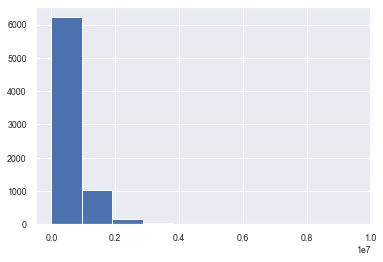

In [88]:
df_copy['Maximum Open Credit'].hist();

### Monthly Debt - текущая сумма кредита

In [89]:
# df_copy['Monthly Debt'].hist();

In [90]:
# def preprocess_outlier(df, col, threshold):
#     # можно по threshold отсекать, а можно и по квантилям
#     df.loc[df[col] > threshold, col] = np.nan
#     return df

# feature_name = 'Monthly Debt'
# df_copy = preprocess_outlier(df_copy, feature_name, threshold=70000)
# df_final_copy = preprocess_outlier(df_final_copy, feature_name, threshold=70000)

# df_copy[feature_name].isna().sum()

In [91]:
# %%time
# monthly_debt_predictor, df_copy = imputer_rfr(df_copy, feature_name,n_est=100, m_depth=5, verb=1)

In [92]:
# df_copy['Monthly Debt'].hist();

In [93]:
# df = df_copy.copy()
# df_final = df_final_copy.copy()

Annual Income
MannwhitneyuResult(statistic=9361624.5, pvalue=0.45720685796373933)


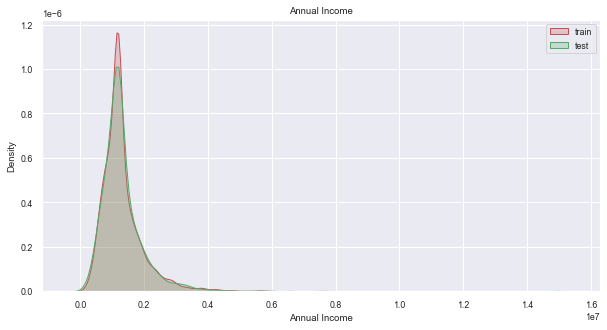

Number of Open Accounts
MannwhitneyuResult(statistic=9279216.5, pvalue=0.22119739091419988)


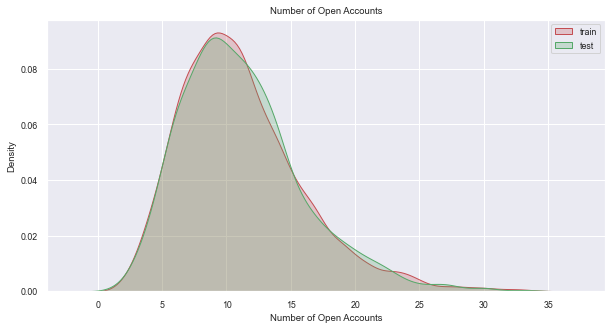

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


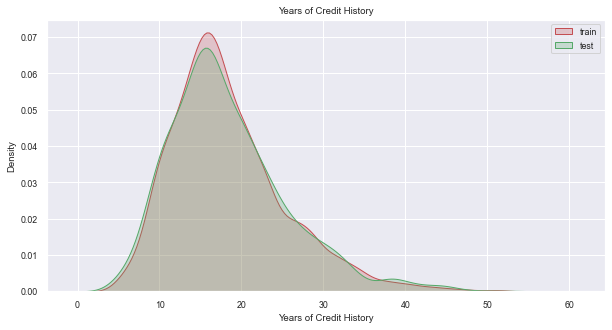

Maximum Open Credit
MannwhitneyuResult(statistic=9332858.5, pvalue=0.3680165255827398)


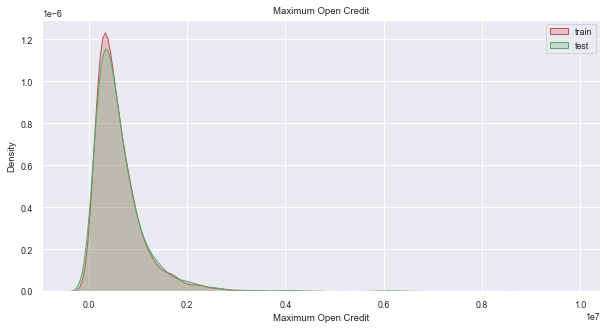

Current Loan Amount
MannwhitneyuResult(statistic=9221649.5, pvalue=0.10977704624662077)


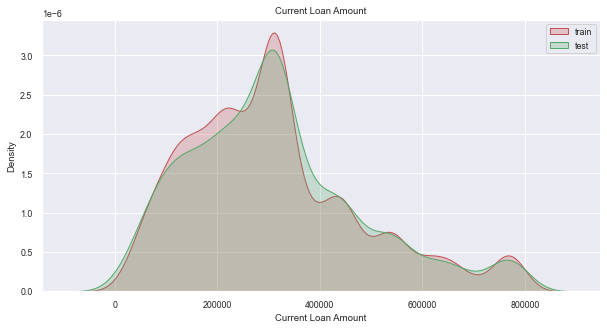

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


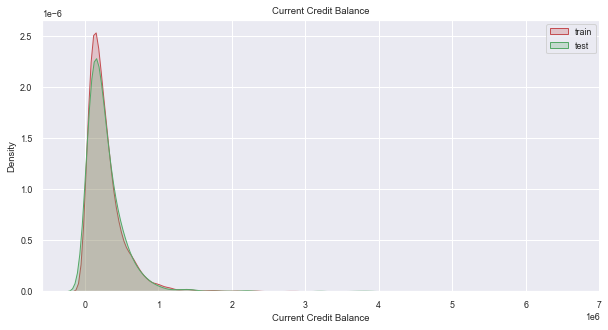

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


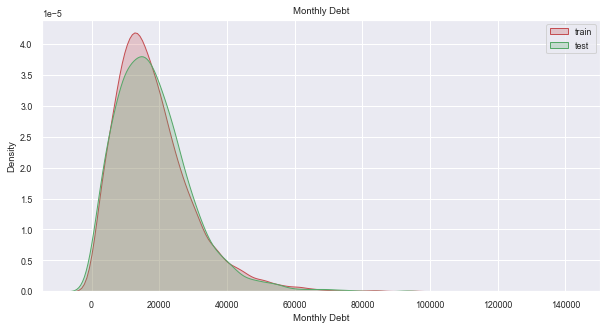

Credit Score
MannwhitneyuResult(statistic=9247418.5, pvalue=0.15114281548880665)


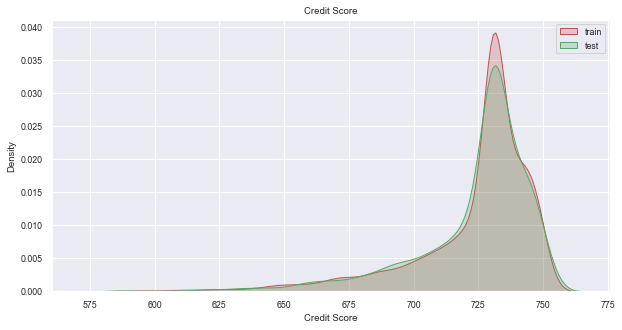

prog_current_loan_amount
MannwhitneyuResult(statistic=9348750.0, pvalue=0.35286157280000413)


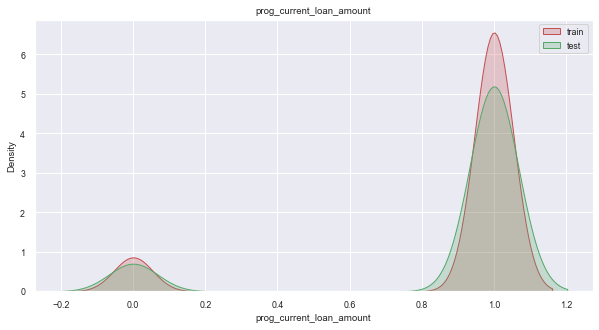

prog_credit_score
MannwhitneyuResult(statistic=9275000.0, pvalue=0.022281931660039042)


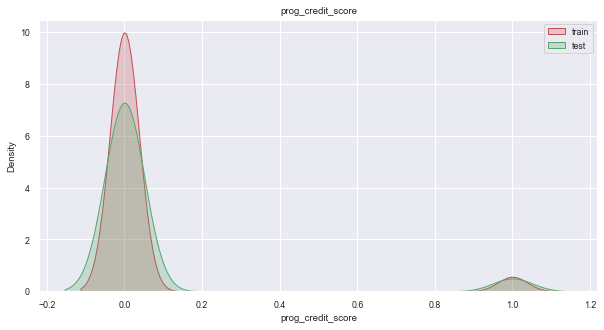

In [94]:
figsize = (10, 5)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df[col], shade=True, label='train', color='r')
    sns.kdeplot(df_final[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df[col], df_final[col]))
    plt.legend()
    plt.title(col)
    plt.show()

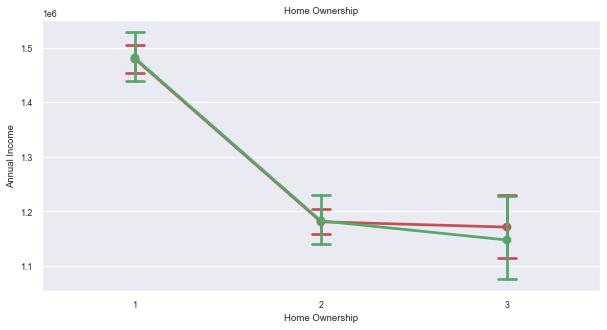

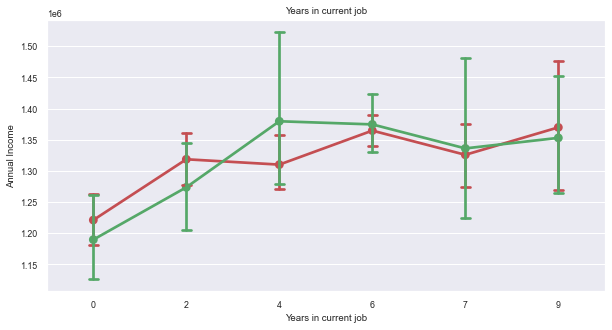

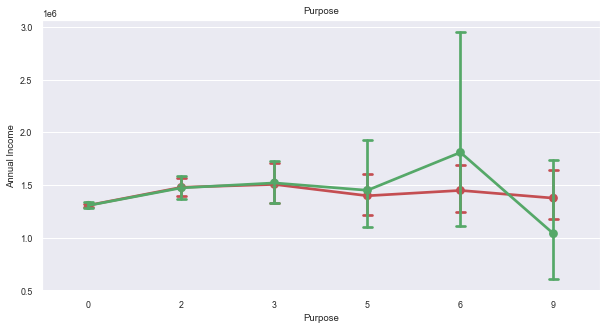

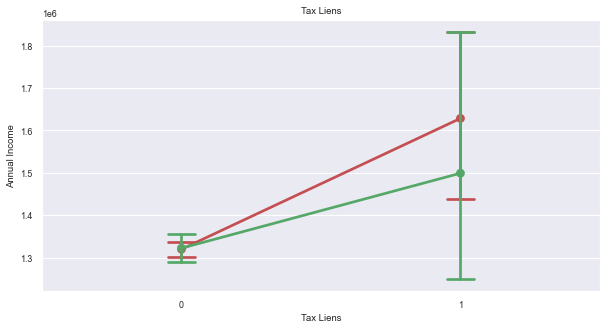

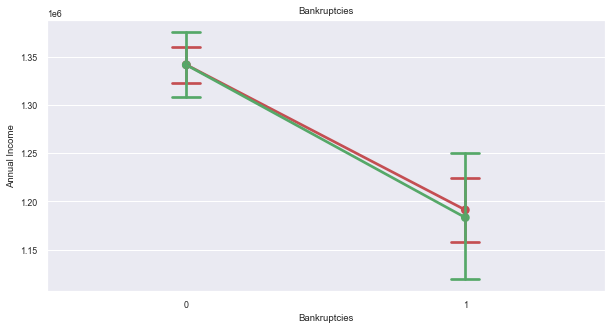

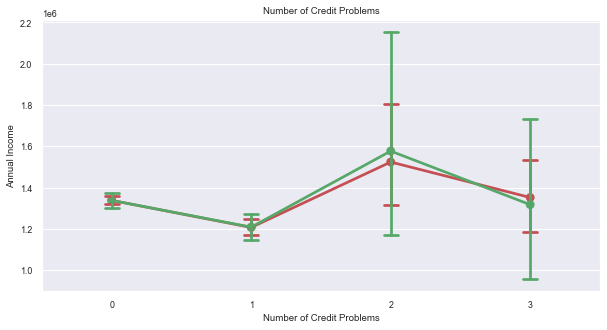

In [95]:
num_feature = 'Annual Income'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_final, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

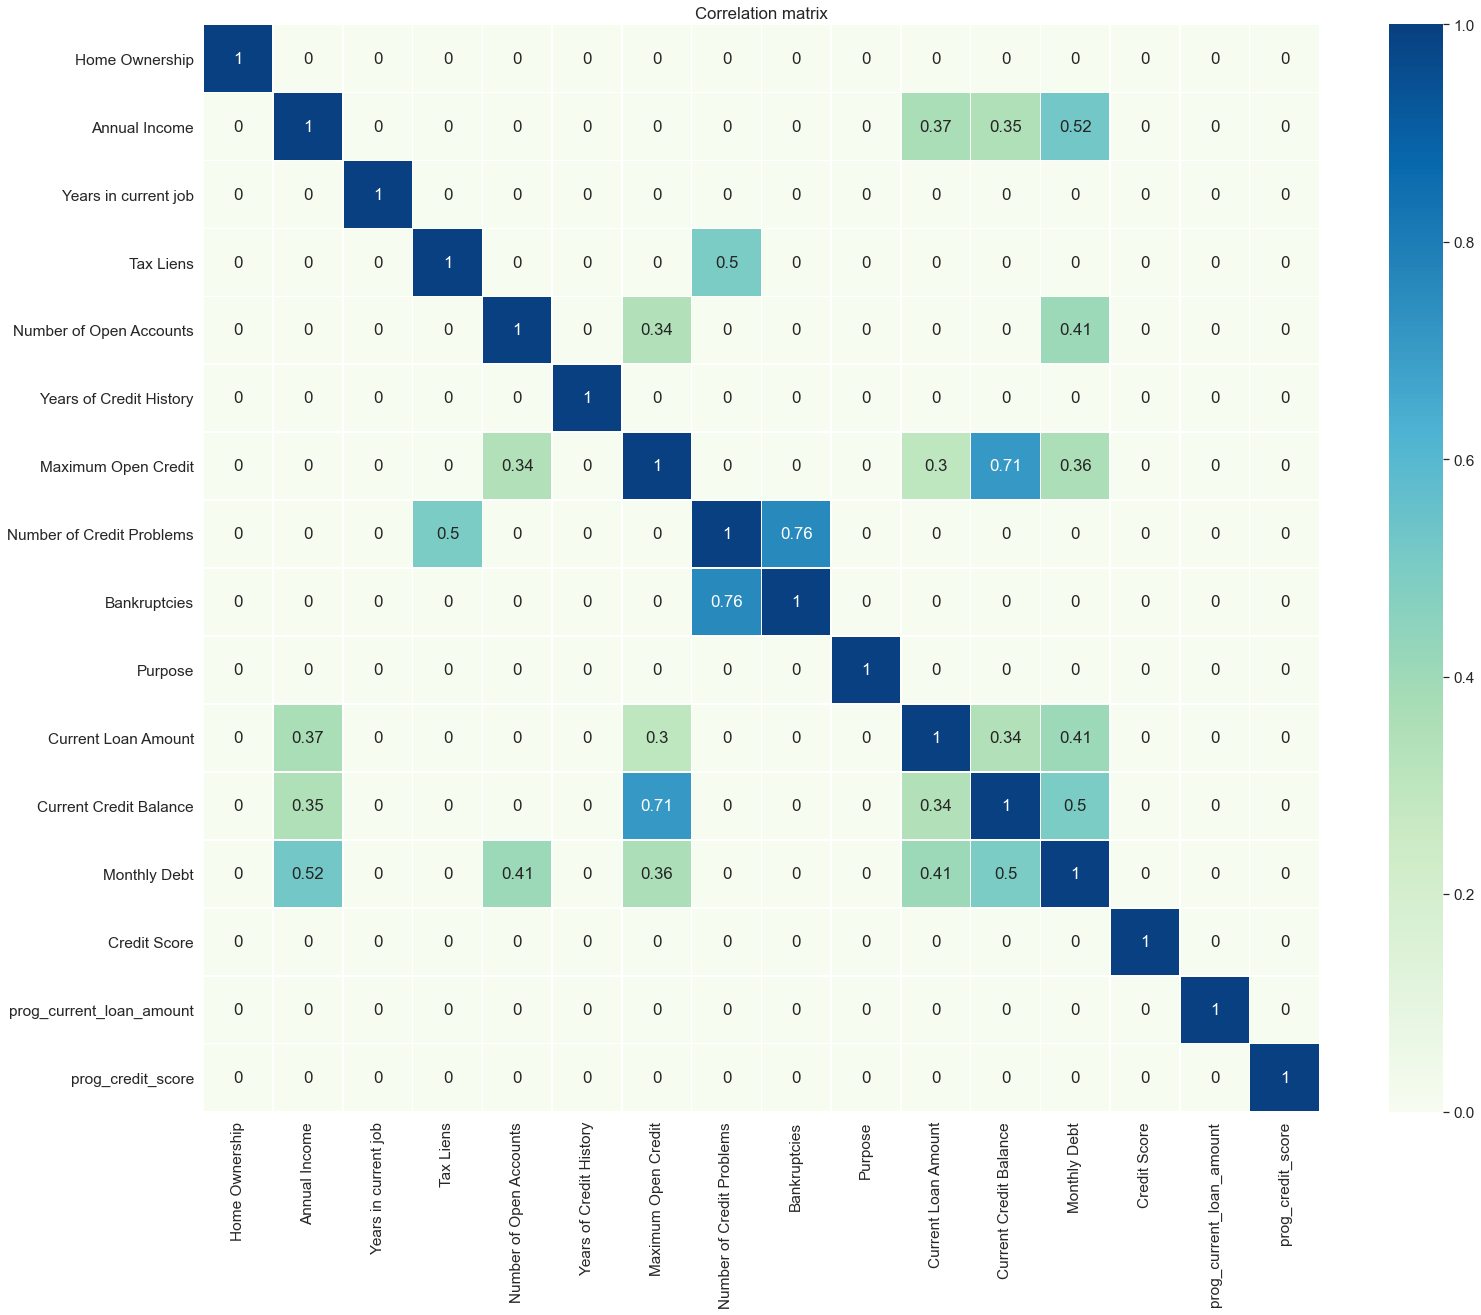

In [96]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = df[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [97]:
df_final.head()

Home Ownership  Annual Income  Years in current job  Tax Liens  \
0               2      1168386.0                     4          0   
1               2       231838.0                     0          0   
2               1      1152540.0                     2          0   
3               1      1220313.0                     6          0   
4               1      2340952.0                     6          0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                      9.0                     12.5             220968.0   
1                      6.0                     32.7              55946.0   
2                     10.0                     13.7             204600.0   
3                     16.0                     17.0             456302.0   
4                     11.0                     23.6            1207272.0   

   Number of Credit Problems  Bankruptcies  Purpose  Current Loan Amount  \
0                          0             0        0             162470.0   
1                          0             0        9              78298.0   
2                          0             0        0             200178.0   
3                          0             0        0             217382.0   
4                          0             0        0             777634.0   

   Current Credit Balance  Monthly Debt  Credit Score  \
0                105906.0        6813.0         731.0   
1                 46037.0        2318.0         699.0   
2                146490.0       18729.0         731.0   
3                213199.0       27559.0         739.0   
4                425391.0       42605.0         706.0   

   prog_current_loan_amount  prog_credit_score  
0                         1                  0  
1                         1                  0  
2                         1                  1  
3                         1                  0  
4                         1                  0

### Масштабрование данных

In [98]:
# scaler = StandardScaler()

# df_norm = df.copy()
# df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

# df = df_norm.copy()

# df_norm_final = df_final.copy()
# df_norm_final[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm_final[NUM_FEATURE_NAMES])

# df_final = df_norm_final.copy

**Сохранение модели для масштабирования данных**

In [99]:
# with open(SCALER_FILE_PATH, 'wb') as file:
#     pickle.dump(scaler, file)

In [100]:
# df_final.head()

### Построение и оценка базовых моделей

### Подготовка для catboost

In [101]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'prog_current_loan_amount',
 'prog_credit_score']

In [102]:
X = df[BASE_FEATURE_NAMES]
y = df[TARGET_NAME]
CAT_FEATURE_NAMES = ['Home Ownership','Years in current job','Purpose', 'Tax Liens','Bankruptcies','Number of Credit Problems']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

### Сохранение обучающего и тестового датасетов

In [103]:
# train = pd.concat([X_train, y_train], axis=1)
# test = pd.concat([X_test, y_test], axis=1)

In [104]:
# df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
# train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
# test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

**Загрузка данных**

In [105]:
# df = pd.read_csv(TRAIN_FULL_PATH)
# df_train = pd.read_csv(TRAIN_PART_PATH)
# df_test = pd.read_csv(TEST_PART_PATH)

In [106]:
# X = df.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
# y = df[TARGET_NAME]

# X_train = df_train.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
# y_train = df_train[TARGET_NAME]

# X_test = df_test.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
# y_test = df_test[TARGET_NAME]

In [107]:
# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')
    
# df_balanced[TARGET_NAME].value_counts()

In [108]:
# X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
# y_train_balanced = df_balanced[TARGET_NAME]

In [109]:
disbalance = y_train.value_counts()[0] /y_train.value_counts()[1]
disbalance

2.5496957403651117

In [110]:
# model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
#                                      cat_features=CAT_FEATURE_NAMES,
#                                      class_weights=[1, disbalance]
#                                      )
# model_catb.fit(X_train_balanced, y_train_balanced)

# evaluate_preds(model_catb, X_train_balanced, X_test, y_train_balanced, y_test)

### Гиперпараметры catboost

In [111]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     cat_features=CAT_FEATURE_NAMES,
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall']
                                    )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [112]:
model_catb.best_score_

{'learn': {'Recall:use_weights=false': 0.7978363759296823,
  'Logloss': 0.5519104213782395,
  'F1': 0.7080309360292105,
  'Precision:use_weights=false': 0.7223198594024605,
  'Precision:use_weights=true': 0.8689802374186761,
  'Recall:use_weights=true': 0.7978363759296823},
 'validation': {'Recall:use_weights=false': 0.7933753943217665,
  'Logloss': 0.5628843714643025,
  'F1': 0.6985265902255023,
  'Precision:use_weights=false': 0.7051282051282052,
  'Precision:use_weights=true': 0.8590973477296909,
  'Recall:use_weights=true': 0.7933753943217665}}

In [113]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.53      0.66      3771
           1       0.40      0.78      0.53      1479

    accuracy                           0.60      5250
   macro avg       0.63      0.66      0.59      5250
weighted avg       0.73      0.60      0.62      5250

TEST

              precision    recall  f1-score   support

           0       0.86      0.53      0.66      1616
           1       0.40      0.79      0.53       634

    accuracy                           0.60      2250
   macro avg       0.63      0.66      0.59      2250
weighted avg       0.73      0.60      0.62      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               862  754
1               135  499


### Выбор лучшей модели и подбор гиперпараметров

In [114]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}
model_catb = catb.CatBoostClassifier(**frozen_params)

**Подбор гиперпараметров**

In [115]:
params = {'iterations':[50, 200, 500, 700, 1500],
          'max_depth':[3, 5, 7]}

In [116]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [117]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7178125617
bestIteration = 46

0:	loss: 0.7178126	best: 0.7178126 (0)	total: 923ms	remaining: 12.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7206486176
bestIteration = 16

1:	loss: 0.7206486	best: 0.7206486 (1)	total: 1.52s	remaining: 9.86s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7206486176
bestIteration = 16

2:	loss: 0.7206486	best: 0.7206486 (1)	total: 2.11s	remaining: 8.43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7206486176
bestIteration = 16

3:	loss: 0.7206486	best: 0.7206486 (1)	total: 2.65s	remaining: 7.28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7206486176
bestIteration = 16

4:	loss: 0.7206486	best: 0.7206486 (1)	total: 3.18s	remaining: 6.36s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7147171908
bestIteration = 17

5:	loss: 0.7147172	best: 0.7206486 (1)	total: 4.04s	remaining: 6.06s
Stopped by overfitting detector  (20 iteration

In [118]:
grid_search

{'params': {'depth': 5, 'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31],
              'test-F1-mean': [0.5588969994681957,
               0.6831186303290426,
               0.6735278450461246,
               0.6577211371598327,
               0.6675324510723097,
               0.6767300453672928,
               0.6810349681715175,
               0.6849830399459075,
              

In [119]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

iterations  test-F1-mean  test-F1-std  train-F1-mean  train-F1-std  \
11          11      0.696204     0.019194       0.704873      0.002090   
10          10      0.695443     0.018166       0.703327      0.003129   
12          12      0.695330     0.016743       0.705969      0.005824   
9            9      0.692662     0.014294       0.698972      0.006236   
18          18      0.692471     0.013969       0.707935      0.004557   

    test-Logloss-mean  test-Logloss-std  train-Logloss-mean  train-Logloss-std  
11           0.599500          0.001962            0.597728           0.002715  
10           0.601609          0.001606            0.599946           0.002511  
12           0.597629          0.002376            0.595560           0.002157  
9            0.603512          0.001217            0.602138           0.003175  
18           0.588963          0.003948            0.585337           0.002363

**Обучение и оценка финальной модели**

In [120]:
%%time

model = catb.CatBoostClassifier(**frozen_params, iterations=200, max_depth=5)
model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.52      0.65      3771
           1       0.40      0.80      0.53      1479

    accuracy                           0.60      5250
   macro avg       0.63      0.66      0.59      5250
weighted avg       0.74      0.60      0.62      5250

TEST

              precision    recall  f1-score   support

           0       0.87      0.52      0.65      1616
           1       0.39      0.80      0.53       634

    accuracy                           0.60      2250
   macro avg       0.63      0.66      0.59      2250
weighted avg       0.73      0.60      0.61      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               838  778
1               129  505
Wall time: 967 ms


In [121]:
# preds_final.value_counts().unique()

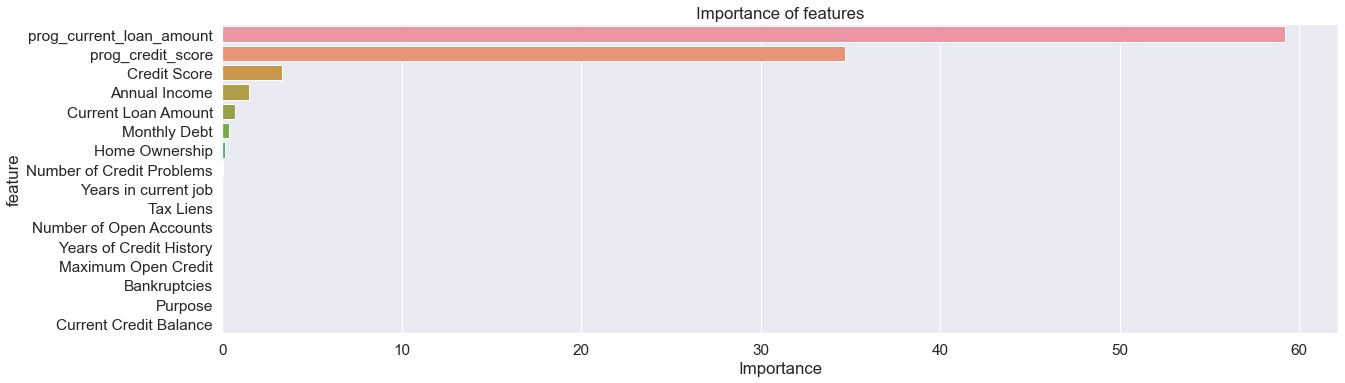

In [122]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top=23)

In [123]:
df_final.head()

Home Ownership  Annual Income  Years in current job  Tax Liens  \
0               2      1168386.0                     4          0   
1               2       231838.0                     0          0   
2               1      1152540.0                     2          0   
3               1      1220313.0                     6          0   
4               1      2340952.0                     6          0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                      9.0                     12.5             220968.0   
1                      6.0                     32.7              55946.0   
2                     10.0                     13.7             204600.0   
3                     16.0                     17.0             456302.0   
4                     11.0                     23.6            1207272.0   

   Number of Credit Problems  Bankruptcies  Purpose  Current Loan Amount  \
0                          0             0        0             162470.0   
1                          0             0        9              78298.0   
2                          0             0        0             200178.0   
3                          0             0        0             217382.0   
4                          0             0        0             777634.0   

   Current Credit Balance  Monthly Debt  Credit Score  \
0                105906.0        6813.0         731.0   
1                 46037.0        2318.0         699.0   
2                146490.0       18729.0         731.0   
3                213199.0       27559.0         739.0   
4                425391.0       42605.0         706.0   

   prog_current_loan_amount  prog_credit_score  
0                         1                  0  
1                         1                  0  
2                         1                  1  
3                         1                  0  
4                         1                  0

In [124]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Home Ownership             2500 non-null   int32  
 1   Annual Income              2500 non-null   float64
 2   Years in current job       2500 non-null   int32  
 3   Tax Liens                  2500 non-null   int32  
 4   Number of Open Accounts    2500 non-null   float64
 5   Years of Credit History    2500 non-null   float64
 6   Maximum Open Credit        2500 non-null   float64
 7   Number of Credit Problems  2500 non-null   int32  
 8   Bankruptcies               2500 non-null   int32  
 9   Purpose                    2500 non-null   int32  
 10  Current Loan Amount        2500 non-null   float64
 11  Current Credit Balance     2500 non-null   float64
 12  Monthly Debt               2500 non-null   float64
 13  Credit Score               2500 non-null   float

In [125]:
y_test_pred_probs = model.predict_proba(df_final)
y_test_pred_probs

array([[0.48776213, 0.51223787],
       [0.47573097, 0.52426903],
       [0.1083645 , 0.8916355 ],
       ...,
       [0.4743829 , 0.5256171 ],
       [0.5689177 , 0.4310823 ],
       [0.11597593, 0.88402407]])

In [126]:
y_test_pred = model.predict(df_final)

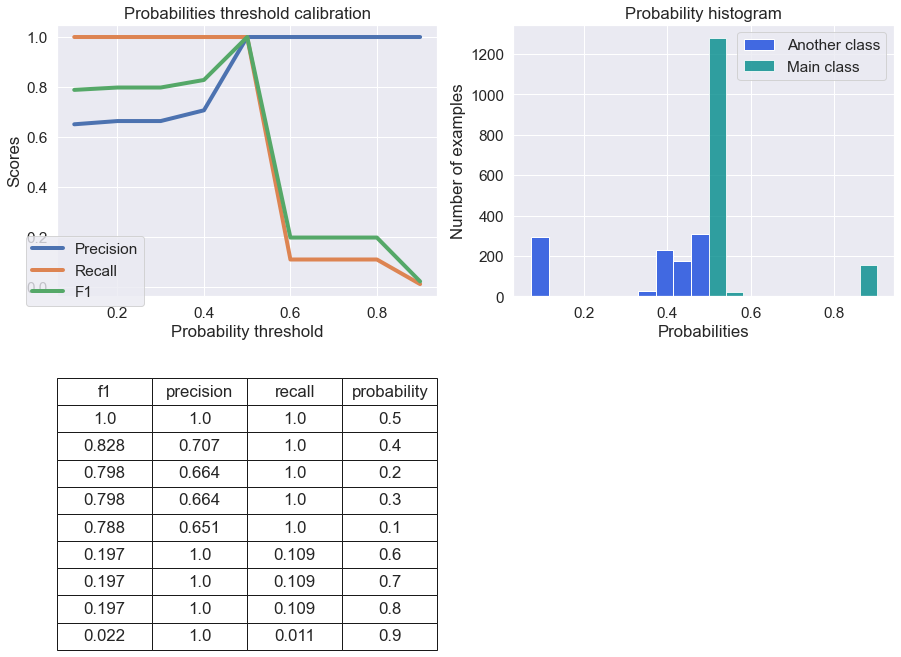

In [127]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test_pred)

In [139]:
pred_test = np.where(y_test_pred_probs[:, 1] >= 0.497, 1, 0)

In [140]:
print(classification_report(y_test_pred, pred_test))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1038
           1       0.99      1.00      1.00      1462

    accuracy                           0.99      2500
   macro avg       1.00      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



In [141]:
preds_final = pd.DataFrame()
df_final['Id'] = df_final.index
preds_final['Id'] = df_final['Id'].copy()


preds_final['Credit Default'] = pred_test

preds_final.to_csv('predictions.csv', index=False)
